<a href="https://colab.research.google.com/github/MohamedAbdelsalam9/IFT6135_Assignment1_Kaggle/blob/master/kaggle_run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<center>IFT6135</center>
#<center>Assignment 1</center>
#<center>Kaggle Competition</center>

**Load the needed modules:**

In [0]:
import time
import numpy as np
import copy
import math
import os
import shutil
import datetime
import csv
from IPython.core.debugger import set_trace
from sklearn.metrics import accuracy_score
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import transforms, datasets
from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Data Loading
**`Acces the google drive to be able to get the data:`**

In [3]:
#mount the google drive account to use the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**`Acces the google drive to be able to get the data: (Put the data in a Data/CatsDogs/ directory in your drive, otherwise change the path in the next cell)`**

In [0]:
#make sure that all data is deleted beforehand so as not to mix the validation set with training set
!rm -r '/content/trainset'
!rm -r '/content/testset'
!rm -r '/content/validationset'

#Unzip the compressed files of the training set and test set
!unzip -q '/content/drive/My Drive/Data/CatsDogs/testset.zip'
!unzip -q '/content/drive/My Drive/Data/CatsDogs/trainset.zip'

In [0]:
#The directories containing the training set, validation set and test set
data_dir = "/content"
TRAIN = "trainset"
VALIDATION = "validationset"
TEST = "testset"

train_dir = os.path.join(data_dir,TRAIN)
train_dogs_dir = f'{train_dir}/Dog'
train_cats_dir = f'{train_dir}/Cat'

val_dir = os.path.join(data_dir,VALIDATION)
val_dogs_dir = f'{val_dir}/Dog'
val_cats_dir = f'{val_dir}/Cat'

test_dir = os.path.join(data_dir,TEST)
test_dir = os.path.join(test_dir,'test')

**Create a Validation Set from the images whose id is a multiple of 10 (10% validation set)**

In [6]:
#Create a directory for the validation set, if not already there
try:  
  os.mkdir(val_dir)
  os.mkdir(val_dogs_dir)
  os.mkdir(val_cats_dir)
except OSError:  
  print (f"Creation of the directory {val_dir} failed (perhaps it already exists)")
else:  
  print (f"Successfully created the directory {val_dir}")

#Move the files used for the validation set from the training folder to the validation folder, in their respective class folder
try:
  files = os.listdir(train_dir)
  for i in range(10, 10000, 10):
    dog_file = str(i) + ".Dog.jpg"
    cat_file = str(i) + ".Cat.jpg"
    shutil.move(f'{train_dogs_dir}/{dog_file}', val_dogs_dir)
    shutil.move(f'{train_cats_dir}/{cat_file}', val_cats_dir)
  print("Succesfully Created the validation set")
except:
  print("Creating the validation set failed (make sure you empty any previously existing validation folder)")

Successfully created the directory /content/validationset
Succesfully Created the validation set


In [7]:
print (f"Training Set: {len(os.listdir(train_dogs_dir))} Dogs, {len(os.listdir(train_cats_dir))} Cats")
print (f"Validation Set: {len(os.listdir(val_dogs_dir))} Dogs, {len(os.listdir(val_cats_dir))} Cats")
print (f"Test Set: {len(os.listdir(test_dir))} Samples")

Training Set: 9000 Dogs, 9000 Cats
Validation Set: 999 Dogs, 999 Cats
Test Set: 4999 Samples


**Specify the directory to which the checkpoints will be saved in SAVE_PATH, check if there is GPU available, and initialize some global variables**

In [9]:
SAVE_PATH = '/content/drive/My Drive/IFT6135/CatsDogs'
SEED = 1000

if (torch.cuda.is_available()):
  DEVICE = torch.device("cuda:0")
  CUDA_AVAILABLE = True
  print ("GPU is available")
else:
  DEVICE = torch.device("cpu")
  CUDA_AVAILABLE = False
  print ("GPU is not available")
  
#These are the mean and standard deviation obtained from Imagenet pictures
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

GPU is available


In [10]:
#Initialize the random seed for numpy and torch
np.random.seed(SEED)
torch.manual_seed(SEED)

# Data Preprocessing
**Create a new ImageFolder class that returns the sample, target and path**

In [0]:
#Create a new ImageFolder class that returns the image path as well
class ImageFolderWithPath(datasets.ImageFolder):
  def __getitem__(self, index):
    path, target = self.samples[index]
    sample = self.loader(path)
    if self.transform is not None:
      sample = self.transform(sample)
    if self.target_transform is not None:
      target = self.target_transform(target)

    return sample, target, path

**Rescale the data to be 128x128, create random transformations on the training set in the form of rotations, shear, and crops with different aspect rations **

In [0]:
data_transforms = {TRAIN: transforms.Compose([transforms.RandomAffine(degrees=10, shear=10), 
                                                transforms.RandomHorizontalFlip(),
                                                transforms.RandomResizedCrop(128, scale=(0.9, 1.1), ratio=(0.8, 1.2)),
                                                transforms.ToTensor(),
                                                transforms.Normalize(MEAN, STD)]),
                   VALIDATION: transforms.Compose([transforms.Resize([128,128]),
                                              transforms.ToTensor(),
                                              transforms.Normalize(MEAN, STD)]),
                   TEST: transforms.Compose([transforms.Resize([128,128]),
                                              transforms.ToTensor(),
                                              transforms.Normalize(MEAN, STD)])}

**Create dataloaders for the data, with a minibatch size of 32**

In [0]:
datasets_ = {dataset_type: ImageFolderWithPath(os.path.join(data_dir, dataset_type),data_transforms[dataset_type]) 
             for dataset_type in [TRAIN, VALIDATION, TEST]}

dataloaders = {dataset_type: torch.utils.data.DataLoader(datasets_[dataset_type], batch_size=32,shuffle=True, num_workers=1) 
               for dataset_type in [TRAIN, VALIDATION]}
dataloaders[TEST] = torch.utils.data.DataLoader(datasets_[TEST], batch_size=32,shuffle=False, num_workers=1)

CLASSES = datasets_[TRAIN].classes

In [14]:
print(f"Classes: {CLASSES}")
print(f"Training Set: {len(datasets_[TRAIN])} Samples")
print(f"Validation Set: {len(datasets_[VALIDATION])} Samples")
print(f"Test Set: {len(datasets_[TEST])} Samples")

Classes: ['Cat', 'Dog']
Training Set: 18000 Samples
Validation Set: 1998 Samples
Test Set: 4999 Samples


**Print a sample of the training set**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


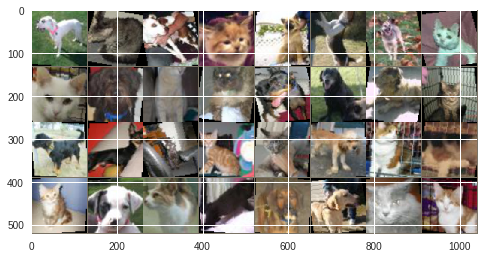

In [16]:
sample_images, _, _ = next(iter(dataloaders[TRAIN]))
sample_images = torchvision.utils.make_grid(sample_images)
sample_images = sample_images.numpy().transpose((1, 2, 0))
sample_images = STD * sample_images + MEAN
plt.imshow(sample_images)
plt.pause(0.001)

##Model

**Create a Dropout Module**

In [0]:
class DropoutLayer(nn.Module):  
  def __init__(self,drop_prob):
    super(DropoutLayer, self).__init__()
    self.drop_prob = drop_prob
    
  def extra_repr(self):
    s = ('{drop_prob}')
    return s.format(**self.__dict__)

  def forward(self, x):
    #dropout is applied during training only not inference
    if self.training:
      mask = (1-self.drop_prob) + torch.empty(x.shape).uniform_(0, 1)
      #used to create a binary mask for the input 
      mask = torch.floor(mask)
      mask = mask.to(DEVICE)
      return x * mask
    return x

**Create a Spatial Dropout Module. It works by masking some feature maps, which works well with convolutional layers  **

In [0]:
#dropout specifically for conv2d layers
class SpatialDropoutLayer(nn.Module):
  def __init__(self,drop_prob):
    super(SpatialDropoutLayer, self).__init__()
    self.drop_prob = drop_prob
      
  def extra_repr(self):
    s = ('{drop_prob}')
    return s.format(**self.__dict__)
      
  def forward(self, x):
    #dropout is applied during training only not inference
    if self.training:
      #batch size x number of channels
      mask_dim = [x.shape[0],x.shape[3]]
      mask = (1-self.drop_prob) + torch.empty(mask_dim).uniform_(0, 1)
      #used to create a binary mask for the input 
      mask = torch.floor(mask)
      mask = mask.view(-1,1,1,x.shape[3])
      mask = mask.to(DEVICE)
      return x * mask
    return x

###Modify the PyTorch Conv2d class to introduce the concept of training levels/stages. Training levels is that as we are not allowed to use pretrained models, so instead of training the whole model starting from random weights initializations, we train a few layers for some epochs and then add other layers and continue training, etc.
###So at the first stage/level, we use a model with only 3 convolutional layers. At the second level, we continue training these 3 conv layers plus 3 more conv layers. At the third level, we continue training the 6 conv layers along with the last 3 layers. This way we avoid training the total 9 layers from scratch concurrently.

In [0]:
from torch.nn.modules.conv import _ConvNd
from torch.nn.modules.utils import _pair

class Conv2d(_ConvNd):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True, level = 0):
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        self.level = level
        super(Conv2d, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            False, _pair(0), groups, bias)

    def forward(self, input, current_level):
      if current_level >= self.level:
        return F.conv2d(input, self.weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)
      else: #if this conv layer shouldn't be active in this level, just return the input
        return input

###**The architecture used is in some sense similar to VGG with 9 convolutional layers (all with filters of size 3), 3 pooling layers, two fully connected layers, a spatial dropout layer, and a dropout layer for a total number of 8,674,769 parameters. A leaky ReLU with alpha 0.2 was used with all the layers.**

###**The model consists of 3 blocks, each block is 3 convolutional layers followed by a maxpool layer, followed at the end with two fully connected layers. A spatial dropout is added after the 7th convolutional layer, and a normal dropout is added after the 1st fully connected layer. Convolutional layers at the first block are of depth 32 channels, at the second block of depth 64 channels, and at the third block of depth 128 channels. Maxpool layers are of width 2, except the first maxpool layer which is of width 4. **

###**The first Maxpool layer is of width 4 since the images were already upsampled to double their original sizes, and so as to decrease the number of parameters needed later for the fully connected layer. It has been proven to perform better when this large maxpooling layer is put after the first 3 layers than in the last maxpooling layer with a difference of 0.8% in validation accuracy between the two architectures, probably as the features present at the final layers are more informative for the model and hence are more valuable not to lose them with a large maxpool**

### **As mentioned before, layers were added successively during the training process to avoid training the whole model from scratch, which resulted in faster convergence and more stable convergence.**

In [0]:
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()
    self.conv00 = Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, level = 0)
    self.conv01 = Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, level = 1)
    self.conv02 = Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, level = 2)
    self.pool0 = nn.MaxPool2d(kernel_size=(4, 4), stride=4)
    self.conv10 = Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, level = 0)
    self.conv11 = Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, level = 1)
    self.conv12 = Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, level = 2)
    self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
    self.conv20 = Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, level = 0)
    self.conv21 = Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, level = 1)
    self.conv22 = Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, level = 2)
    self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
    self.FC0 = nn.Linear(8192, 1000)
    self.FC1 = nn.Linear(1000, 1)
    self.dropout = DropoutLayer(0.2)
    self.spatial_dropout =  SpatialDropoutLayer(0.2)
    self.relu = nn.LeakyReLU(0.2)

    self.conv_layers = (self.conv00, self.relu, self.conv01, self.relu, self.conv02, self.relu, self.pool0, 
                        self.conv10, self.relu, self.conv11, self.relu, self.conv12, self.relu, self.pool1, 
                        self.conv20, self.spatial_dropout, self.relu, self.conv21, self.relu, self.conv22, self.relu, self.pool2)
    self.FC_layers = (self.FC0, self.relu, self.dropout, self.FC1)

    self.levels_no = 3
    self.level = 0

  def define_learning_level (self, level):
    self.level = level

  def forward(self, x):
    for layer in self.conv_layers:
      if isinstance(layer, Conv2d):
        x = layer(x, self.level)
      else:
        x = layer(x)
        
    x = x.view(x.size(0), -1)
    
    for FC_layer in self.FC_layers:
      x = FC_layer(x)
    return x

## Training

**Print the information of the network and save them in a Log File**

In [0]:
def print_network_info(model, optimizer, levels_interval, checkpoint = None, LOG_PATH = None):
  summary(model, (3, 128, 128))
  print(f'''
  Learning Levels: {model.levels_no}
  Learning Levels Interval: {levels_interval}''')
  
  if LOG_PATH is not None:
    if checkpoint is None: 
      with open(LOG_PATH, "w") as file:
        file.write(f'Training Data Transformations: {data_transforms[TRAIN].transforms}\n\n')
        file.write(f'Optimizer Parameters: {optimizer.defaults}\n\n')
        file.write(f'seed: {SEED}\n\n')
        file.write(f'Learning Levels: {model.levels_no}\nLearning Levels Interval: {levels_interval}\n\n')
        file.write("Layers:\n")
        parameters = 0
        for module in model.children():
          try:
            params = np.product(next(iter(module.parameters())).shape)
          except:
            params = 0

          file.write(f'{module}, parameters = {params}\n')
          parameters += params
        file.write (f'Total parameres = {parameters}\n\n')

**Initialize some statistics regarding the training process and save them in a variable called stats. Moreover, if a checkpoint is provided, load the model and these statistics from that checkpoint**

In [0]:
def init_stats(model, optimizer, levels_interval, checkpoint = None):
  if checkpoint is not None:
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.define_learning_level(checkpoint['level'])
    stats = {'epoch_0': checkpoint['epoch']+1, 'seed': checkpoint['seed'], 'date_': checkpoint['date_'], 'total_time': checkpoint['total_time'], 
             'levels_interval': checkpoint['levels_interval'], 'train_loss': checkpoint['train_loss'], 'train_accuracy': checkpoint['train_accuracy'], 
             'validation_loss': checkpoint['validation_loss'], 'val_accuracy': checkpoint['val_accuracy'], 'best_val_accuracy': checkpoint['best_val_accuracy']}
  else:
    date = datetime.datetime.now()
    stats = {'epoch_0': 1, 'seed': SEED, 'date_': f'{date.year}_{date.month}_{date.day}_{date.hour}_{date.minute}', 'total_time': 0, 
            'levels_interval': levels_interval, 'train_loss': [], 'train_accuracy': [], 'validation_loss': [], 'val_accuracy': [], 'best_val_accuracy': 0}
  np.random.seed(stats['seed'])
  torch.manual_seed(stats['seed'])
  return stats

In [0]:
def init_logging(stats, save_interval):
  if save_interval > 0:
    save_directory = os.path.join(SAVE_PATH,f"{stats['date_']}")
    log_path = os.path.join(save_directory, stats['date_'] + ".txt")
    if not os.path.exists(save_directory):
      os.makedirs(save_directory)
      print_network_info(model, optimizer, stats['levels_interval'], checkpoint, log_path)
    return log_path, save_directory
  else:
    print_network_info(model, optimizer, stats['levels_interval'])
    return -1, -1

In [0]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [0]:
def Train(model, optimizer, criterion, stats):
  model.train()
  train_losses = []; train_accuracy = [];
  
  for batch_idx, (inputs, targets, _) in enumerate(dataloaders[TRAIN]):
    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
    targets = torch.unsqueeze(targets.float(),dim=1) 
    optimizer.zero_grad() #reset the gradient to zero
    predicted_train = model(inputs)
    loss = criterion(predicted_train, targets)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.data.item())  
    predicted_train = np.round(sigmoid(predicted_train.cpu().detach().numpy())[:, 0]).astype(int)
    train_accuracy.append(accuracy_score(targets.cpu().numpy(),predicted_train)* 100)

  stats['train_accuracy'].append(np.mean(train_accuracy))
  stats['train_loss'].append(np.mean(train_losses))

In [0]:
def Validate(model, criterion, stats):
  model.eval()
  val_losses = [];  val_accuracy = [];
  for batch_idx, (inputs, targets, _) in enumerate(dataloaders[VALIDATION]):
    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
    targets = torch.unsqueeze(targets.float(),dim=1)
    predicted_val = model(inputs)
    loss = criterion(predicted_val, targets)
    val_losses.append(loss.data.item())  
    predicted_val = np.round(sigmoid(predicted_val.cpu().detach().numpy())[:, 0]).astype(int)
    val_accuracy.append(accuracy_score(targets.cpu().numpy(),predicted_val)*100)

  stats['val_accuracy'].append(np.mean(val_accuracy))
  stats['validation_loss'].append(np.mean(val_losses))

In [0]:
def model_save(epoch, model, optimizer, stats, path):
  torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'levels_interval': stats['levels_interval'],
              'level':model.level, 'train_loss': stats['train_loss'], 'train_accuracy': stats['train_accuracy'], 
              'validation_loss': stats['validation_loss'], 'val_accuracy': stats['val_accuracy'], 'date_': stats['date_'], 
              'total_time': stats['total_time'], 'best_val_accuracy': stats['best_val_accuracy'], 'seed': stats['seed']}, path)

In [0]:
def ModelTrain(model, optimizer, criterion, epochs, levels_interval = 10, lr_Step = 10, lr_step_Factor = 2, save_interval = 5, checkpoint = None):
  
  #initialize the model stats, or load them from a checkpoint along with the model parameters
  stats = init_stats(model, optimizer, levels_interval, checkpoint = checkpoint)

  log_path, save_directory = init_logging(stats, save_interval)
  
  levels_no = model.levels_no
  for epoch in range(stats['epoch_0'], epochs+1):
      start = time.time()
      level = model.level
      
      #increase the training level if the levels_interval has passed
      if (level < (levels_no-1)):
        new_level = math.ceil(epoch/stats['levels_interval']) - 1
        if level < new_level:
          model.define_learning_level(new_level)   
      
      #Train
      Train(model, optimizer, criterion, stats)
      
      #decrease the learning rate every lr_step by a factor of lr_step_Factor (don't do that except when the final learning level is reached)
      if level == (levels_no - 1):
        if (epoch % lr_Step == 0):
          optimizer.param_groups[0]['lr'] /= lr_step_Factor     
      
      end = time.time(); epoch_time = end-start; stats['total_time'] += epoch_time
      e_hours = math.floor(epoch_time/60/60); e_mins = math.floor(epoch_time/60) - e_hours*60; e_secs = epoch_time % 60
      t_hours = math.floor(stats['total_time']/60/60); t_mins = math.floor(stats['total_time']/60) - t_hours*60; t_secs = stats['total_time'] % 60
      
      
      # Evaluate
      Validate(model, criterion, stats)
      
      #Save best model
      if (stats['val_accuracy'][-1] > stats['best_val_accuracy']):
        stats['best_val_accuracy'] = stats['val_accuracy'][-1]
        if save_interval > 0:
          best_check_point_path = os.path.join(save_directory,'Best_'+stats['date_']+'.'+'tar')
          model_save(epoch, model, optimizer, stats, best_check_point_path)
        
      #Print Epoch Statistics
      print(f"Epoch : {epoch},  lr: {optimizer.param_groups[0]['lr']},  Train Loss: {stats['train_loss'][-1]:.3f},  Validation Loss: {stats['validation_loss'][-1]:.3f},  "\
            f"Train Acc: {stats['train_accuracy'][-1]:.1f}%,  Validation Acc : {stats['val_accuracy'][-1]:.1f}%,  Best Validation Acc : {stats['best_val_accuracy']:.1f}%,  "\
            f"\nEpoch Time : {e_hours}H {e_mins}M {e_secs:.0f}S,  Total Time : {t_hours}H {t_mins}M {t_secs:.0f}S")
      print('--------------------------------------------------------------')
      
      if save_interval > 0:
        with open(log_path, "a") as file: 
          file.write(f"Epoch : {epoch},  lr: {optimizer.param_groups[0]['lr']},  Train Loss: {stats['train_loss'][-1]:.3f},  Validation Loss: {stats['validation_loss'][-1]:.3f},  "\
                     f"Train Acc: {stats['train_accuracy'][-1]:.1f}%,  Validation Acc : {stats['val_accuracy'][-1]:.1f}%, Best Validation Acc : {stats['best_val_accuracy']:.1f}%,  "\
                     f"\nEpoch Time : {e_hours}H {e_mins}M {e_secs:.0f}S,  \Total Time : {t_hours}H {t_mins}M {t_secs:.0f}S\n")
          file.write('--------------------------------------------------------------\n')
      
        if (epoch % save_interval == 0):
          check_point_path = os.path.join(save_directory,str(epoch)+'_'+stats['date_']+'.'+'tar')
          model_save(epoch, model, optimizer, stats, check_point_path)
  return stats

**Test method with a technique similar to ensembling. It works by applying transformations on the test set similar to those applied on the training set, and getting a score for each transformation of the image, and taking the average of these scores**

In [0]:
def Test(model, submission_path, checkpoint = None): 
  if checkpoint is not None:
    model.load_state_dict(checkpoint['model_state_dict'])
    model.define_learning_level(checkpoint['level'])
    
  model.eval()
  index = []
  output = []
  
  # Augmenting Test set during prediction
  n_transformation = 7
  test_data_transform = transforms.Compose([transforms.RandomAffine(degrees=10, shear=10), 
                                                transforms.RandomHorizontalFlip(),
                                                transforms.Resize([128,128]),
                                                transforms.ToTensor(),
                                                transforms.Normalize(MEAN, STD)])
  
  for batch_idx, (inputs, _, Paths) in enumerate(dataloaders[TEST]):
    predictions = []
    
    for i in range(n_transformation):
        output_transformed_image = []
        for img_index, input_img_path in enumerate(Paths): 
            transformed_image = test_data_transform(Image.open(input_img_path))
            transformed_image = torch.unsqueeze(transformed_image,dim=0)
            if transformed_image.size()[1]!=3:
              transformed_image = torch.unsqueeze(inputs[img_index],dim=0)
            output_transformed_image.append(transformed_image)
        output_transformed_image = torch.cat(output_transformed_image,0)
        output_transformed_image = output_transformed_image.to(DEVICE)
        transformed_output = model(output_transformed_image)
        predictions.append(transformed_output)
    
    inputs = inputs.to(DEVICE)
    outputs = model(inputs)
    predictions.append(outputs)
    predictions = torch.cat(predictions,dim=1)
    predictions = torch.unsqueeze(predictions.mean(1),dim=1)
    predicted = np.round(sigmoid(predictions.cpu().detach().numpy()))[:,0].astype(int)
    index += [path[:-4].replace(test_dir+'/','') for path in Paths]
    output += predicted.tolist()
    
  with open(os.path.join(submission_path,'submission_file.csv'), mode='w') as submission_file:
    submission_writer = csv.writer(submission_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    submission_writer.writerow(['id', 'label'])
    for i in range(len(index)):
      submission_writer.writerow([index[i], CLASSES[output[i]]])
  print('Done')  

In [173]:
#checkpoint = torch.load(os.path.join(SAVE_PATH,'93.3_2019_2_16_1_50/50_2019_2_16_1_50.tar'))
checkpoint = None

model = Classifier()
model = model.to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.16)
criterion = nn.BCEWithLogitsLoss()
stats = ModelTrain(model, optimizer, criterion, 80, levels_interval = 10, lr_Step = 10, lr_step_Factor = 2, save_interval = 5, checkpoint = checkpoint)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         LeakyReLU-2         [-1, 32, 128, 128]               0
            Conv2d-3         [-1, 32, 128, 128]           9,248
         LeakyReLU-4         [-1, 32, 128, 128]               0
            Conv2d-5         [-1, 32, 128, 128]           9,248
         LeakyReLU-6         [-1, 32, 128, 128]               0
         MaxPool2d-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          18,496
         LeakyReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,928
        LeakyReLU-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,928
        LeakyReLU-13           [-1, 64, 32, 32]               0
        MaxPool2d-14           [-1, 64,

KeyboardInterrupt: ignored

In [0]:
#submission_path = os.path.join(SAVE_PATH,f"{stats['date_']}")
submission_path = os.path.join(SAVE_PATH,"94.4_2019_2_16_16_39")
checkpoint = torch.load(os.path.join(submission_path,'Best_2019_2_16_16_39.tar'))
Test(model, submission_path = submission_path, checkpoint = checkpoint)

## Results

### The reported validation accuracy for our model was 94.4%, as opposed to a test accuracy of 94% and 93.3%

In [0]:
def Validate_train(model, criterion, stats):
  model.eval()
  val_losses = [];  val_accuracy = [];
  for batch_idx, (inputs, targets, _) in enumerate(dataloaders[TRAIN]):
    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
    targets = torch.unsqueeze(targets.float(),dim=1)
    predicted_val = model(inputs)
    loss = criterion(predicted_val, targets)
    val_losses.append(loss.data.item())  
    predicted_val = np.round(sigmoid(predicted_val.cpu().detach().numpy())[:, 0]).astype(int)
    val_accuracy.append(accuracy_score(targets.cpu().numpy(),predicted_val)*100)

  stats['train_accuracy'].append(np.mean(val_accuracy))
  stats['train_loss'].append(np.mean(val_losses))

In [0]:
stats = init_stats(model, optimizer, 10, checkpoint = None)

for i in range(5,79,5):
  checkpoint = torch.load(os.path.join(SAVE_PATH,'94.4_2019_2_16_16_39/' + str(i) + '_2019_2_16_16_39.tar'))
  model = Classifier()
  model = model.to(DEVICE)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.16)
  criterion = nn.BCEWithLogitsLoss()
  model.load_state_dict(checkpoint['model_state_dict'])
  model.define_learning_level(checkpoint['level'])
  Validate_train(model, criterion, stats)
  Validate(model, criterion, stats)

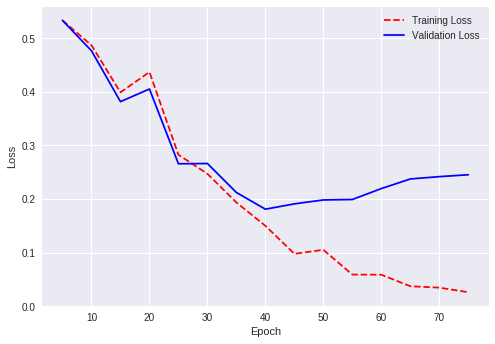

In [192]:
epoch_count = range(1, stats['train_loss'], 1)
plt.plot(epoch_count, stats['train_loss'], 'r--')
plt.plot(epoch_count, stats['validation_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

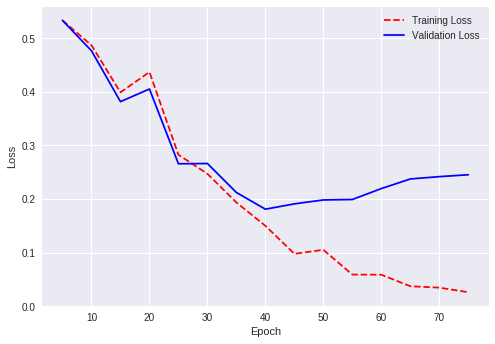

In [190]:
epoch_count = range(1,len(stats['train_accuracy']),1)
plt.plot(epoch_count, stats['train_accuracy'], 'r--')
plt.plot(epoch_count, stats['val_accuracy'], 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [0]:

sample_images, _, _ = next(iter(dataloaders[TRAIN]))
sample_images = torchvision.utils.make_grid(sample_images)
sample_images = sample_images.numpy().transpose((1, 2, 0))
sample_images = STD * sample_images + MEAN
plt.imshow(sample_images)
plt.pause(0.001)

In [216]:
(STD * sample_images[idx, :,:,:].numpy()).shape

ValueError: ignored

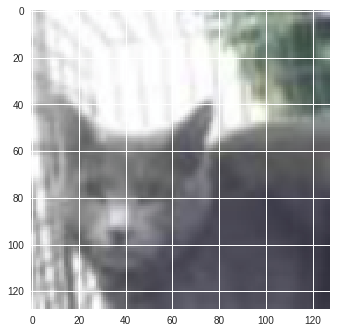

In [254]:
sample_images, targets, _ = next(iter(dataloaders[VALIDATION]))
idx = 1
pred = targets[idx]
img = sample_images[idx, :,:,:]
img = img.numpy().transpose((1, 2, 0))
img = STD * img + MEAN

fig, axarr = plt.subplots(1)
axarr.imshow(img)
#axarr[1].imshow(pred.detach().numpy())


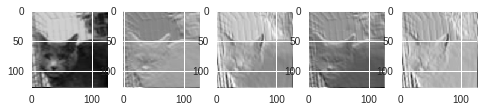

In [255]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

sample_images = sample_images.to(DEVICE)
model.conv00.register_forward_hook(get_activation('conv00'))
output = model(sample_images)

act = activation['conv00'].squeeze()
fig, axarr = plt.subplots(1,5)

for idx in range(5):
    axarr[idx].imshow(act[1,idx].cpu().numpy())

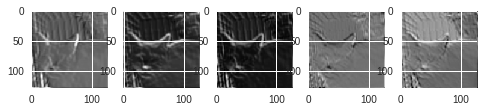

In [256]:
model.conv01.register_forward_hook(get_activation('conv01'))
output = model(sample_images)

act = activation['conv01'].squeeze()
fig, axarr = plt.subplots(1,5)

for idx in range(5):
    axarr[idx].imshow(act[1,idx].cpu().numpy())

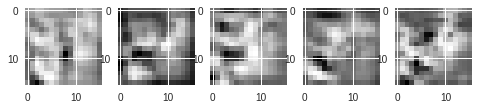

In [257]:
model.conv21.register_forward_hook(get_activation('conv21'))
output = model(sample_images)

act = activation['conv21'].squeeze()
fig, axarr = plt.subplots(1,5)

for idx in range(5):
    axarr[idx].imshow(act[1,idx].cpu().numpy())